# Medical Insurance Premium Prediction 

In [1]:

import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from math import sqrt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt 
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

In [3]:
data = pd.read_csv("insurance.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Data Manipulation

In [6]:
data.duplicated().sum()

1

In [7]:
data[data.duplicated(keep =False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


There is a highly likely chance that this is actually a duplicated observation, thus we will drop it from our df. 

In [9]:
df_cleaned = data.drop_duplicates(keep = 'last')

In [10]:
df_cleaned.duplicated().sum()

0

In [11]:
df_cleaned.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [12]:
df = df_cleaned.copy()

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


### Exploratory Data Analysis (EDA)

In [16]:
# Checking to see if there are any noticable patterns between the variables and the regions 
df_region = df.groupby(['region']).mean(numeric_only = True)
df_region

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.259259,29.195494,1.151235,12450.840844
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


The region `southeast` appears to have the highest `bmi` and `charges` 

In [18]:
df_age = df.groupby(['age']).mean(numeric_only = True)
df_age

,bmi,children,charges
age,,,
18,31.326159,0.449275,7086.217556
19,28.567164,0.432836,9868.929428
20,30.632759,0.862069,10159.697736
21,28.185714,0.785714,4730.464330
22,31.087679,0.714286,10012.932802
23,31.454464,1.000000,12419.820040
24,29.142679,0.464286,10648.015962
25,29.693929,1.285714,9838.365311
26,29.428929,1.071429,6133.825309


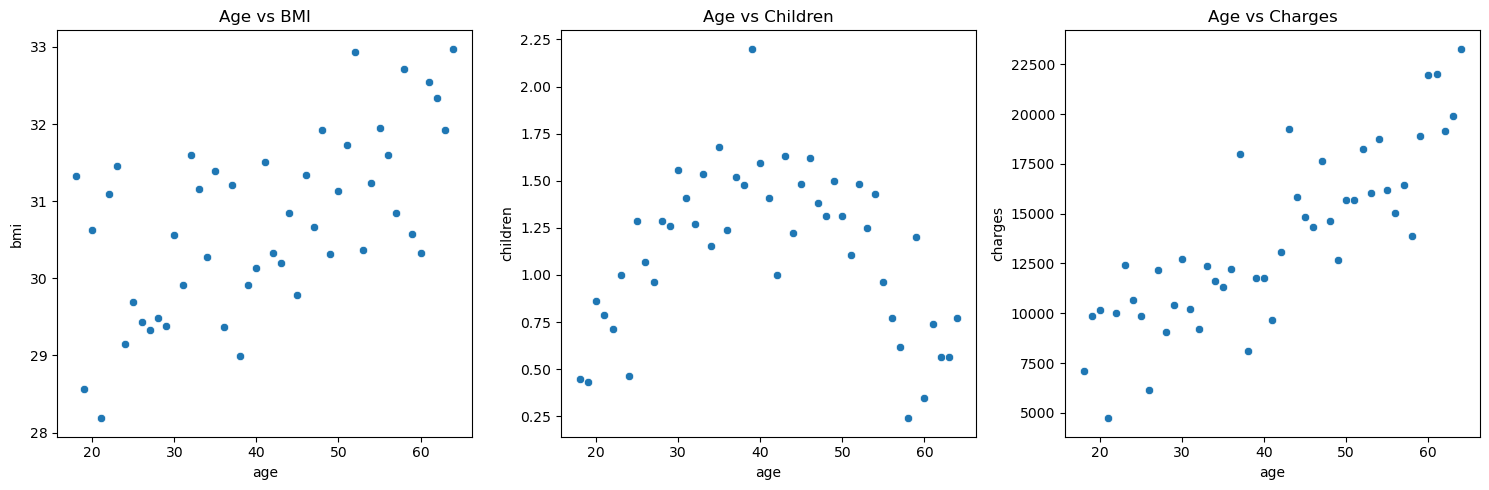

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))

sns.scatterplot(data = df_age, x = 'age', y = 'bmi', ax = axs[0])
axs[0].set_title('Age vs BMI')

sns.scatterplot(data = df_age, x = 'age', y = 'children', ax = axs[1])
axs[1].set_title('Age vs Children')

sns.scatterplot(data = df_age, x = 'age', y = 'charges', ax = axs[2])
axs[2].set_title('Age vs Charges')

plt.tight_layout()
plt.show();

There appears to be a positive correlation between age and bmi, and charges. 

### Feature Engineering

In [22]:
df2 = df.copy()

We want to convert the categorical features to numerical.

In [24]:
le_sex = LabelEncoder()
X = df2['sex']
df2['sex'] = le_sex.fit_transform(X) 

In [25]:
le_smoker = LabelEncoder()
X = df2['smoker']
df2['smoker'] = le_smoker.fit_transform(X)

In [26]:
enc = OneHotEncoder(sparse_output = False).set_output(transform = 'pandas')
region_enc = enc.fit_transform(df2[['region']])
df2 = pd.concat([df2, region_enc], axis = 1).drop(columns = ['region', 'region_northwest'])

In [27]:
df2.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,0.0,0.0


### Data Visualisation

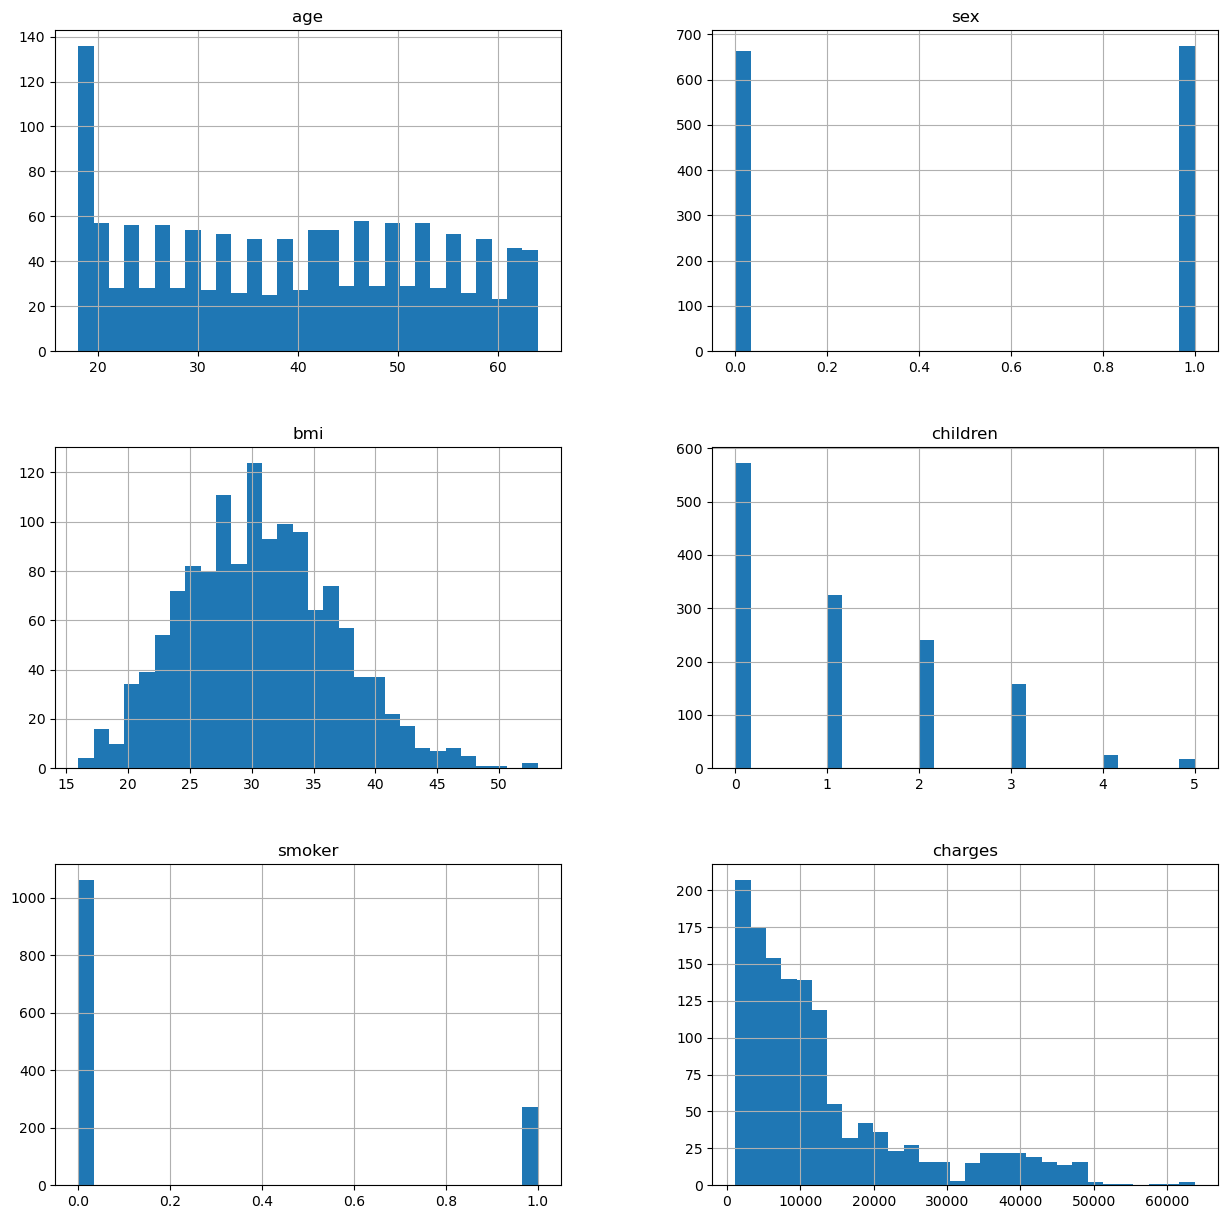

In [29]:
df2[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 30 , figsize = (15,15));

The BMI is distributed normally and the charges is right skewed.  

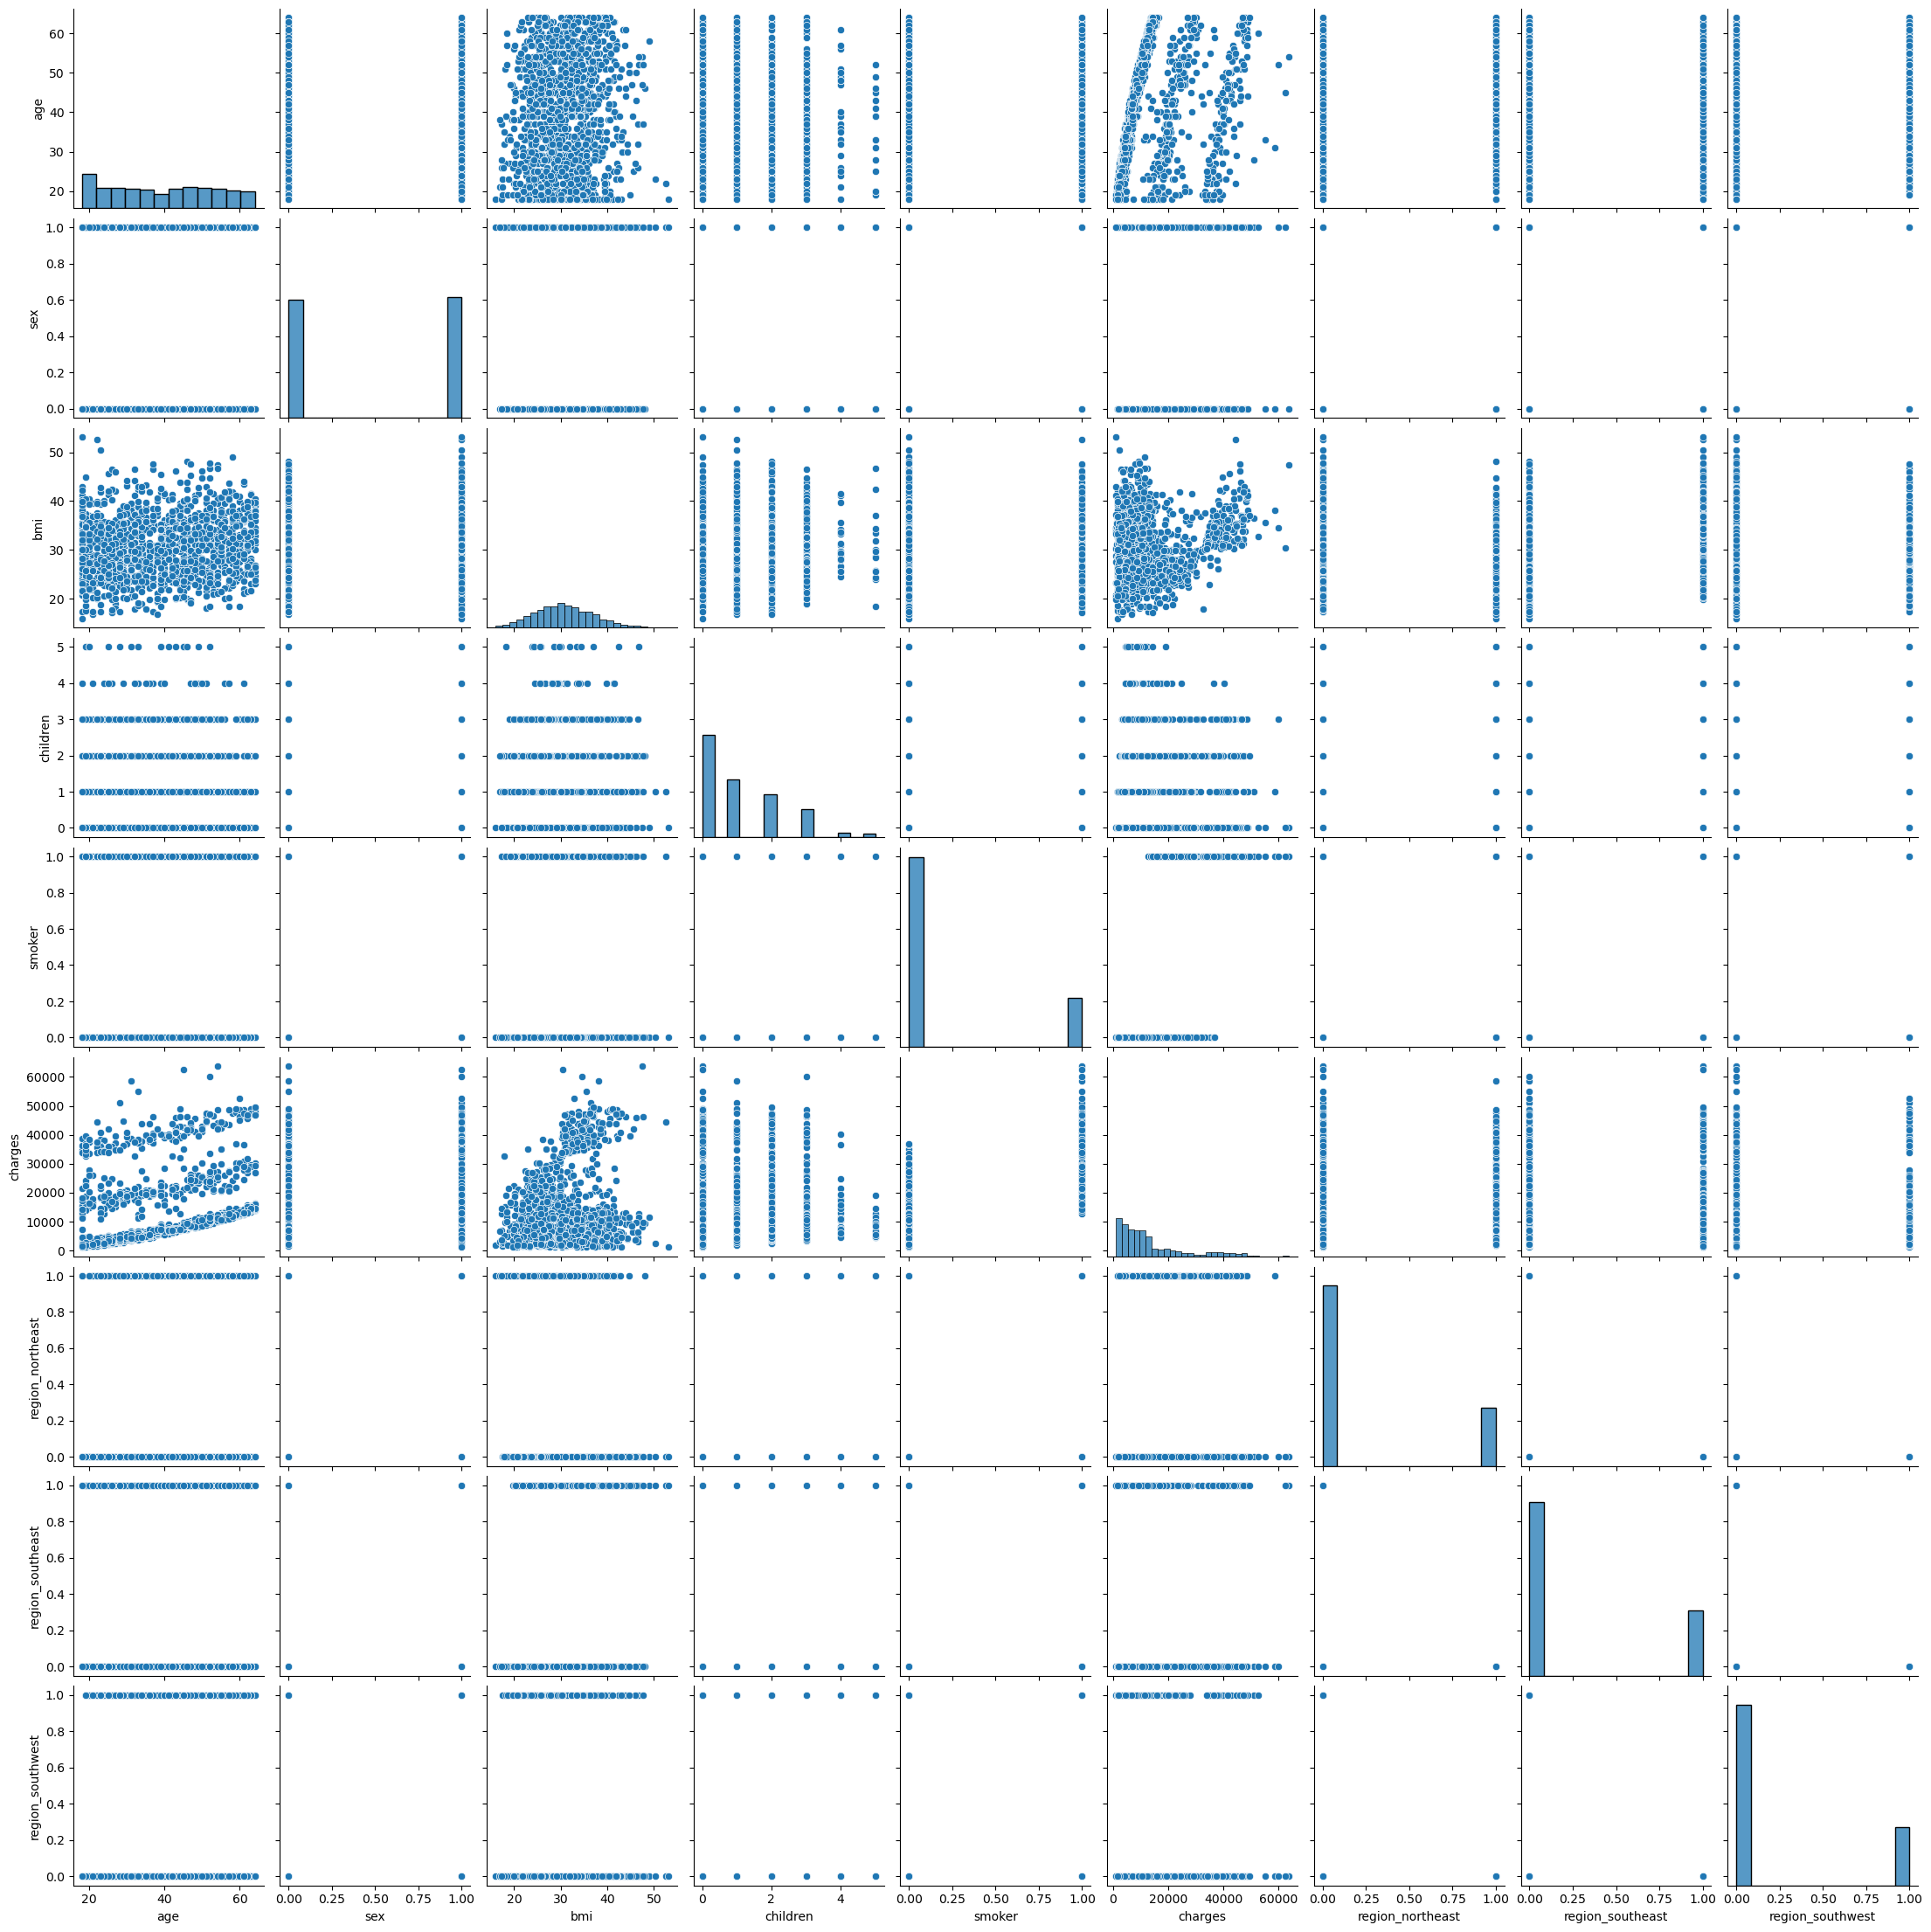

In [31]:
# Investigating the linear relationship between the features
sns.pairplot(df2);

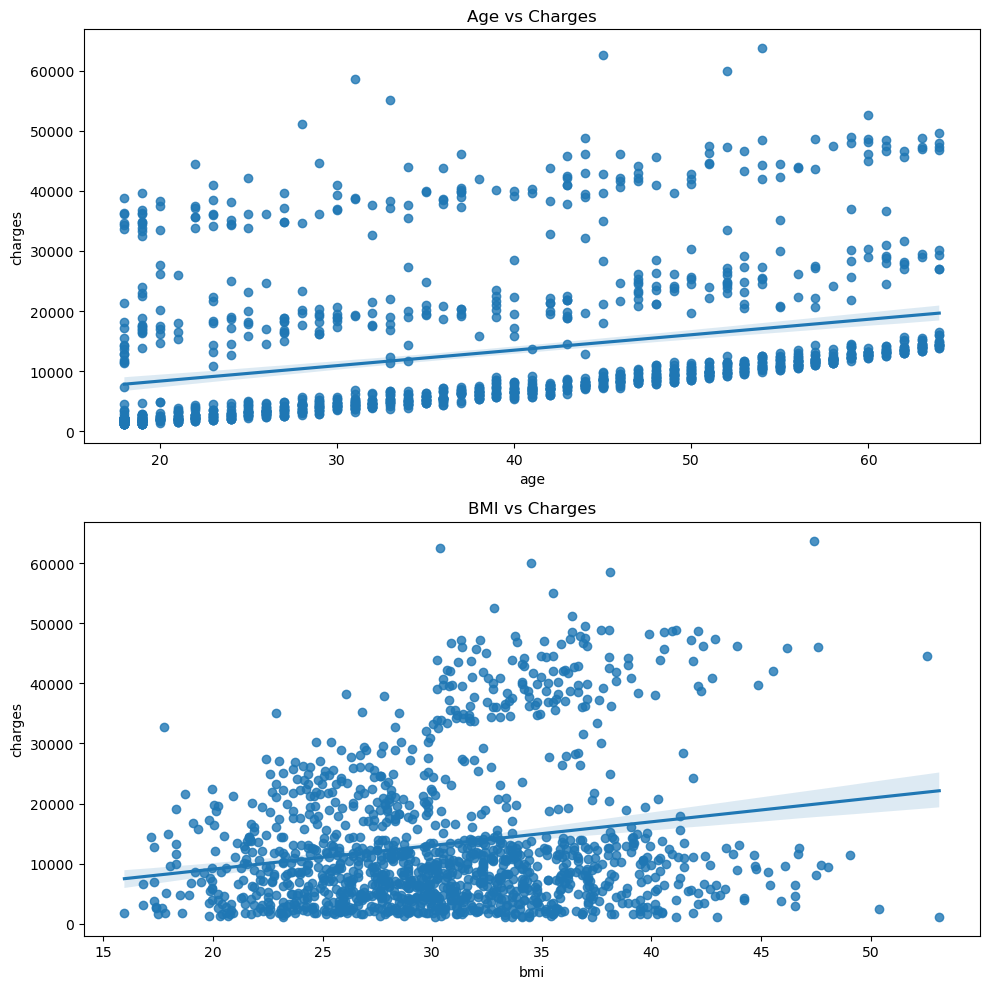

In [32]:
# Investigating the correlation between age/bmi and charges
fig, axs = plt.subplots(2, 1, figsize = (10,10))

sns.regplot(data = df2, x = 'age', y = 'charges', ax = axs[0])
axs[0].set_title('Age vs Charges')

sns.regplot(data = df2, x = 'bmi', y = 'charges', ax = axs[1])
axs[1].set_title('BMI vs Charges')

plt.tight_layout()
plt.show();

<Axes: >

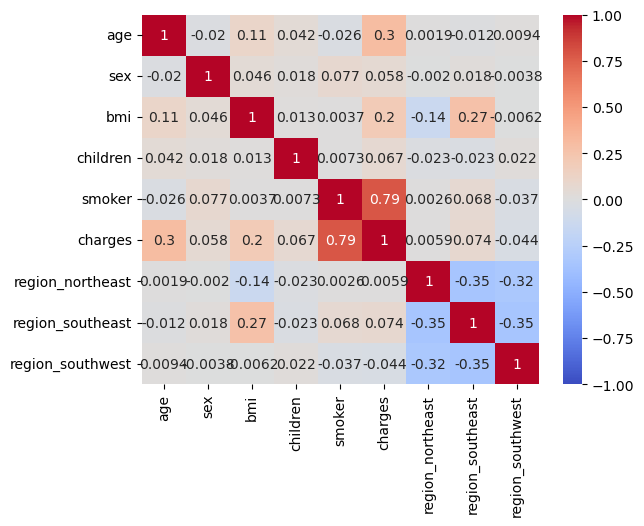

In [33]:
sns.heatmap(df2.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')

There appears to be stroong colinearity between smokers and charges. However, since charges is our target variable, we won't drop it.

### Preapring and splitting the data for Modelling

In [36]:
X = df2.drop(['charges'], axis = 1)
y = df2['charges']
# Converting the data into a numpy array to prepare it for machine learning 
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)
# Reshaping y to get a column to fit the array
y = y.reshape(-1,1)

In [37]:
# Scaling the data before feeding to the model 

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Modelling with Sklearn Linear Regression

In [40]:
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [41]:
# Chekcking the accuracy of our model 

LR_acc = LR.score(X_test,y_test)
LR_acc

0.7787597179412842

In [42]:
y_pred = LR.predict(X_test)

Since we scaled our model, we would want to transform our predictions back into the form of the original data to get meaningful insights

In [44]:
y_pred_df = scaler_y.inverse_transform(y_pred)
y_test_df = scaler_y.inverse_transform(y_test)

**Evaluating our model**

In [46]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test_df, y_pred_df)),'.3f'))
MSE = mean_squared_error(y_test_df, y_pred_df)
MAE = mean_absolute_error(y_test_df, y_pred_df)
r2 = r2_score(y_test_df, y_pred_df)

k = X_test.shape[1]
n = len(X_test)
n

adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 6126.912 
MSE = 37539052.0 
MAE = 4139.7705 
R2 = 0.7787597179412842 
Adjusted R2 = 0.7719260412753779


Based on the R2 and adjusted R2, we can see that out model performs moderately well. 

### Modelling with TensorFlow

In [49]:
base_model = keras.Sequential()
base_model.add(Dense(50, input_dim = 8))
base_model.add(Activation('relu'))
base_model.add(Dense(150))
base_model.add(Activation('relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(150))
base_model.add(Activation('relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(50))
base_model.add(Activation('linear'))
base_model.add(Dense(1))
base_model.compile(loss = 'mse', optimizer = 'adam')
base_model.summary()

C:\Users\Al-Amin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,351 (149.81 KB)

 Trainable params: 38,351 (149.81 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
base_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
base_hist = base_model.fit(X_train, y_train, epochs = 100, batch_size = 20, validation_split = 0.2)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.1827 - val_mean_squared_error: 0.1827
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - val_loss: 0.2090 - val_mean_squared_error: 0.2090
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - val_loss: 0.2127 - val_mean_squared_error: 0.2127
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 0.2151 - val_mean_squared_error: 0.2151
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.2128 - va

In [106]:
result_base = base_model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2259 - mean_squared_error: 0.2259 


In [116]:
base_hist.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

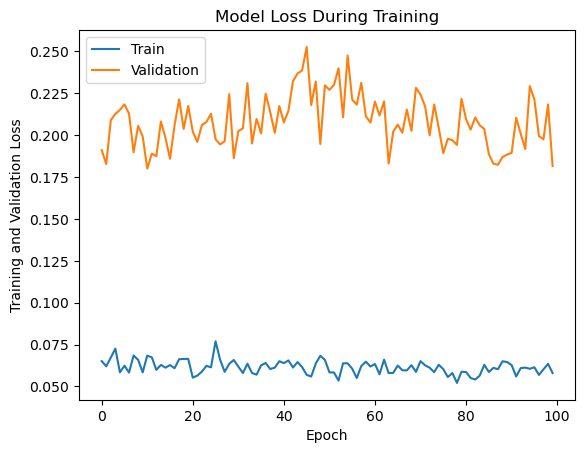

In [114]:
# Plotting training & validation MSE values
plt.plot(base_hist.history['loss'])
plt.plot(base_hist.history['val_loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

Based on the graph, it shows that the model is overfitting, which is to be expected as we have not finely tuned anything.

In [120]:
y_pred_base = base_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


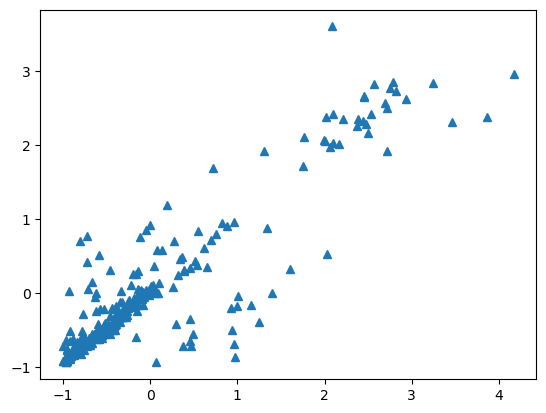

In [130]:
plt.plot(y_test, y_pred_base, '^')

The model is not as accuracte as it could be.

### Fine Tuning the Model

In [137]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Input(shape=(8,)))

    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop'])
    hp_dropout = hp.Float('dropout_rate', min_value = 0.2, max_value =0.5, step = 0.1)
    hp_layer_1 = hp.Int('layer_1', min_value = 50, max_value = 200, step = 50)
    hp_layer_2 = hp.Int('layer_2', min_value = 50, max_value = 200, step = 50)
    hp_layer_3 = hp.Int('layer_3', min_value = 50, max_value = 200, step = 50)
    hp_layer_4 = hp.Int('layer_4', min_value = 50, max_value = 200, step = 50)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model.add(Dense(units = hp_layer_1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(units = hp_layer_2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units = hp_layer_3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units = hp_layer_4))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1))  # Output layer

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=hp_optimizer, metrics = ['mean_squared_error'])
    
    return model

In [139]:
tuner = kt.Hyperband(build_model, objective = 'val_mean_squared_error', max_epochs = 10, factor = 3, directory = 'dir', project_name = 'x')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Reloading Tuner from dir\x\tuner0.json


In [141]:
tuner.search(X_train, y_train, epochs = 50, validation_split = 0.2, callbacks=[early_stopping])

In [143]:
best_hps = tuner.get_best_hyperparameters(num_trials =1)[0]
print("Best hyperparameters:")
for param_name, param_value in best_hps.values.items():
    print(f"{param_name}: {param_value}")

Best hyperparameters:
optimizer: adam
dropout_rate: 0.2
layer_1: 50
layer_2: 150
layer_3: 50
layer_4: 50
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015


In [70]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9718 - mean_squared_error: 0.9718 - val_loss: 0.6917 - val_mean_squared_error: 0.6917
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4554 - mean_squared_error: 0.4554 - val_loss: 0.6220 - val_mean_squared_error: 0.6220
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3658 - mean_squared_error: 0.3658 - val_loss: 0.5024 - val_mean_squared_error: 0.5024
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3786 - mean_squared_error: 0.3786 - val_loss: 0.4529 - val_mean_squared_error: 0.4529
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3347 - mean_squared_error: 0.3347 - val_loss: 0.3692 - val_mean_squared_error: 0.3692
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2807 - mean_squared_error: 0.2807 - val_loss: 0.3248 - val_mean_squared_error: 0.3248
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2780 - mean_squared_error: 0.2780 - val_loss: 0.2751 - v

In [135]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

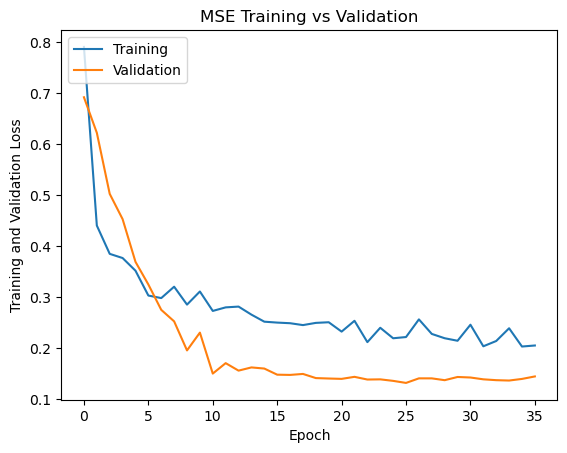

In [190]:
# Plotting training & validation MSE values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

In [153]:
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Text(0, 0.5, 'True Values')

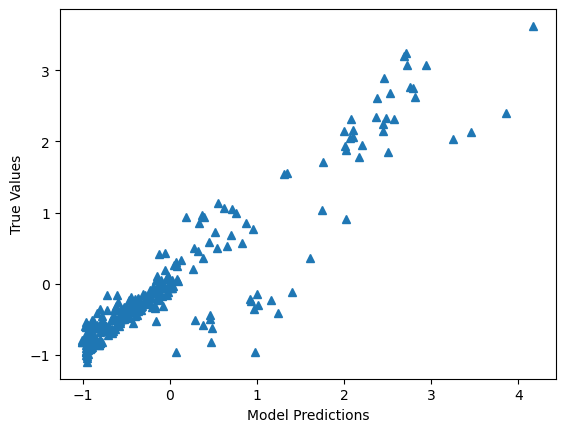

In [155]:
plt.plot(y_test, y_pred, "^")
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

For the most part, this model performs much better than the base model. More importantly, the model is not overfitting or underfitting. 

In [162]:
# Transforming the target variable back to original values

y_pred_org = scaler_y.inverse_transform(y_pred)
y_test_org = scaler_y.inverse_transform(y_test)

Text(0, 0.5, 'True Values')

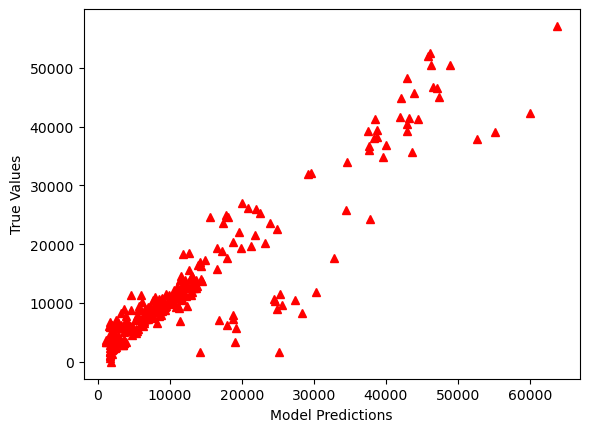

In [192]:
plt.plot(y_test_org, y_pred_org, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

#### Evaluating our model

In [185]:
#Unscaled
k = X_test.shape[1]
n = len(X_test)
n

RMSE = float(format(np.sqrt(mean_squared_error(y_test_org, y_pred_org)),'.3f'))
MSE = mean_squared_error(y_test_org, y_pred_org)
MAE = mean_absolute_error(y_test_org, y_pred_org)
r2 = r2_score(y_test_org, y_pred_org)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 4937.917 
MSE = 24383022.0 
MAE = 2875.1782 
R2 = 0.856296181678772 
Adjusted R2 = 0.8518574536997379


In [187]:
#Scaled
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 0.408 
MSE = 0.16637896 
MAE = 0.2375036 
R2 = 0.856296181678772 
Adjusted R2 = 0.8518574536997379


#### **Conclusion** 

Our updated neural network model demonstrated a marked improvement over the base model, not only in performance metrics but also in the quality of the model's fit.

The model demonstrates a high level of success, as reflected by the R² and Adjusted R² values. With an R² of 0.8563, the model explains approximately 85.63% of the variance in the target variable, indicating a strong fit to the data. The Adjusted R² of 0.8519, which accounts for the number of predictors in the model, further confirms this strong performance by showing that about 85.19% of the variance is explained after adjusting for the complexity of the model.

The consistency of these values before and after scaling suggests that the model's ability to explain variance is robust and not dependent on the scale of the data. This robustness, combined with the high proportion of explained variance, indicates that the model is well-suited for the task at hand and is likely to perform effectively in predicting the target variable.